In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [6]:
! ls ../data

FINAL_ALL_SEQUENCES_TRAINTEST.tsv  FINAL_TARGETS_DATES_TRAINTEST.tsv  pTTQL
FINAL_FEATURES_FRIENDS.tsv	   archive			      pTTSL
FINAL_FEATURES_TRAINTEST.tsv	   pSS_				      pXE_
FINAL_SEQUENCES_MATRIX.csv	   pTTE


In [11]:
user_features_df = pd.read_csv('../data/FINAL_FEATURES_TRAINTEST.tsv', sep='\t', index_col=0)
user_features_df.head(5)

,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,i1067,i1068,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
CLIENT_ID,,,,,,,,,,,,,,,,,,,,,
7150,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7154,0.0,16.0,156.0,0.0,0.0,20.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7156,0.0,5.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26966,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26993,0.0,27.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
user_features_df.isna().any()

i1047    False
i1048    False
i1056    False
i1058    False
i1059    False
         ...  
u8=21     True
u8=6      True
u8=7      True
u8=8      True
u8=9      True
Length: 1014, dtype: bool

In [11]:
user_features_df.isna().sum().value_counts()

1    702
0    312
dtype: int64

In [12]:
user_features_df.shape[0] - user_features_df.dropna().shape[0]

1

In [3]:
user_features_df = user_features_df.fillna(value=0.)

In [14]:
user_features_df.isna().sum().value_counts()

0    1014
dtype: int64

In [12]:
targ_df = pd.read_csv('../data/FINAL_TARGETS_DATES_TRAINTEST.tsv', sep='\t', index_col=0).drop('RETRO_DT', axis=1)
targ_df.head()

,TARGET
CLIENT_ID,
1011725,0
1018784,1
1021812,0
1024003,0
1025140,test


In [16]:
targ_df['TARGET'].value_counts()

0       92491
1       34941
test    31858
Name: TARGET, dtype: int64

In [17]:
targ_df.shape[0] == user_features_df.shape[0]

False

In [13]:
targ_join_uf = targ_df.merge(right=user_features_df, how='inner', left_index=True, right_index=True)
#targ_join_uf = targ_join_uf.dropna()
targ_join_uf.shape

(99973, 1015)

In [5]:
targ_join_uf['TARGET'].value_counts() # WTF? В таблице призаков отсутствуют огромная часть пользователей, как из трейна

0       56279
1       23611
test    20082
Name: TARGET, dtype: int64

In [18]:
targ_join_uf[targ_join_uf['TARGET'] != 'test'].isna().any().sum(), targ_join_uf[targ_join_uf['TARGET'] == 'test'].isna().any().sum()

(702, 0)

In [37]:
tr_data = targ_join_uf[targ_join_uf['TARGET'] != 'test']
test_data = targ_join_uf[targ_join_uf['TARGET'] == 'test']

In [38]:
tr_data.to_csv('train_num_features_with_target.csv')

In [11]:
tr_data.isna().sum()

RETRO_DT    0
TARGET      0
i1047       0
i1048       0
i1056       0
           ..
u8=21       0
u8=6        0
u8=7        0
u8=8        0
u8=9        0
Length: 1016, dtype: int64

In [35]:
y = tr_data['TARGET'].astype(float).values
X = tr_data.drop('TARGET', axis=1).values

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, y, stratify=y, train_size=0.85, shuffle=True)

# Prediction over user features

## Dimension reduction

In [47]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

sfm_selector = SelectFromModel(estimator=LogisticRegression(random_state=0))
sfm_selector.fit(X_train, y_train)

X_train_transformed = sfm_selector.transform(X_train)
Xt_train, Xt_val, y_train, y_val = train_test_split(X_train_transformed, y_train, stratify=y_train, shuffle=True, train_size=0.88)
Xt_train.shape, Xt_val.shape

((59757, 171), (8149, 171))

In [54]:
Xt_test = sfm_selector.transform(X_test)

In [39]:
from sklearn.decomposition import SparsePCA, TruncatedSVD, KernelPCA, FastICA
import pickle

transformer = FastICA(n_components=64, random_state=0)
transformer.fit(X_train)

X_train_transformed = transformer.transform(X_train)

Xt_train, Xt_val, y_train, y_val = train_test_split(X_train_transformed, y_train, stratify=y_train, shuffle=True, train_size=0.88)
Xt_train.shape, Xt_val.shape

/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


((59757, 64), (8149, 64))

In [41]:
Xt_test = transformer.transform(X_test)
Xt_test.shape

(11984, 64)

## MLP classifier

In [44]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(64, 1)
        #self.linear2 = nn.Linear(64, 32)
        #self.linear3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        #x = F.elu(self.linear2(x))
        #x = self.linear3(x)
        return x

In [45]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def train_epoch(model, X, y, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    loss_val = 0.
    aucroc = 0.
    out = model(X).squeeze(-1)
    loss = criterion(out, y.to(torch.float))
    
    loss.backward()
    optimizer.step()
    
    loss_val = loss.item()
    aucroc = roc_auc_score(y.detach(), out.detach()).item()
    return loss_val, aucroc

@torch.no_grad()
def eval_epoch(model, X, y, criterion):
    model.eval()
    loss_val = 0.
    aucroc = 0.
    out = model(X).squeeze(-1)
    loss = criterion(out, y.to(torch.float))
    
    loss_val = loss.item()
    aucroc = roc_auc_score(y.detach(), out.detach()).item()
    return loss_val, aucroc

import matplotlib.pyplot as plt
def plot_hist(train_hist):
    train_loss_hist, val_loss_hist, train_aucroc_hist, val_aucroc_hist = train_hist
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.plot(train_loss_hist, label='train loss')
    ax1.plot(val_loss_hist, label='val loss')
    ax1.set_title('Loss plots')
    ax1.legend()
    ax2.plot(train_aucroc_hist, label='train aucroc')
    ax2.plot(val_aucroc_hist, label='val aucroc')
    ax2.set_title('Training and Validation Metric (F1-Score)')
    ax2.legend()
    plt.show()

def train_model(model, X_train, y_train, criterion, optimizer, do_eval=False, epochs=100, X_val=None, y_val=None):
    train_loss_hist = []
    val_loss_hist = []
    train_auc_hist = []
    val_auc_hist = []
    
    with tqdm(range(1, epochs + 1)) as tepoch:
        for e in tepoch:
            model.train()
            tr_loss, tr_auc = train_epoch(model, X_train, y_train, criterion, optimizer)
            train_loss_hist.append(tr_loss)
            train_auc_hist.append(tr_auc)
            if do_eval:
                model.eval()
                val_loss, val_auc = eval_epoch(model, X_val, y_val, criterion)
                val_loss_hist.append(val_loss)
                val_auc_hist.append(val_auc)
    
    return train_loss_hist, val_loss_hist, train_auc_hist, val_auc_hist
    

In [46]:
Xt_train = torch.from_numpy(Xt_train).to(torch.float)
Xt_val = torch.from_numpy(Xt_val).to(torch.float)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)

In [47]:
Xt_test = torch.from_numpy(Xt_test).to(torch.float)
y_test = torch.from_numpy(y_test)

In [48]:
# pos_weights = torch.from_numpy((targ_df['TARGET'].value_counts() / len(targ_df)).values)
# weights = []
# for y in yt_train:
#     weights.append(pos_weights[y.to(int)])
# weights = torch.Tensor(weights)

100%|██████████| 500/500 [00:55<00:00,  8.97it/s]


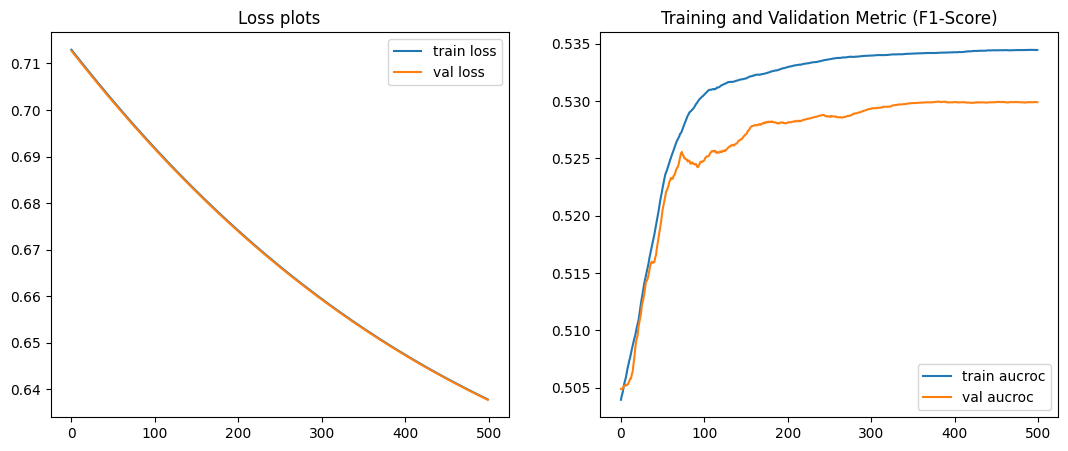

In [49]:
model = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
hist = train_model(model, Xt_train, y_train, criterion, optimizer, epochs=500, do_eval=True, X_val=Xt_val, y_val=y_val)
plot_hist(hist)

In [50]:
eval_epoch(model, Xt_test, y_test, nn.BCEWithLogitsLoss())

(0.6377843618392944, 0.526262037664652)

Experiment logs

1. SparsePCA 64 with weights - 0.512 (don't know about overfit)
2. SparsePCA 32 - 0.505 - overfitted
3. SparsePCA 16 - 0.4999 (huge overfit)
4. LSA (TruncatedSVD) 64, 10 it - 0.492, not stable at all
5. LSA (TruncatedSVD) 32, 10 it - 0.509, huge overfit
6. LSA (TruncatedSVD) 8, 10 it - 0.498, still huge overfit

1-6 - 2-3 layers

7. FastICA 16 - 0.519, good learning graph
8. FASTICA 32 - 0.52-0.53, underfitting (?), still not bad
9. FASTICA 64 - 0.524 - underfit, good
10. SparsePCA 64 (1-3 layer) - about 0.53, kinda overfitting, on train about 0.54
11. SFM with Logreg 0.51-0.52 - a bit overfit

In [ ]:
X_sub = torch.from_numpy(test_data.drop('TARGET', axis=1).values).to(torch.float).to(DEVICE)
model.eval()
out = torch.sigmoid(model(X_sub))
preds = torch.shape()
preds = out[out > 1]

In [9]:
from sklearn.decomposition import FastICA
import pickle
# Fit PCA over all data available
X = pd.read_csv('train_num_features_with_target.csv').drop(['TARGET', 'CLIENT_ID'], axis=1)
transformer = FastICA(n_components=64, random_state=0)
transformer.fit(X)
with open('FastICATransformer', 'wb') as tr_file:
    pickle.dump(transformer, tr_file)

/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [ ]:
X_transformed = transformer.transform(X)

#add weights for target class imbalance before
pos_weights = torch.from_numpy((targ_df['TARGET'].value_counts() / len(targ_df)).values)
weights = []
for y in yt_train:
    weights.append(pos_weights[y.to(int)])
weights = torch.Tensor(weights)

#Fit model over all data
model = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
hist = train_model(model, Xt_train, y_train, criterion, optimizer, epochs=200, do_eval=True, X_val=Xt_val, y_val=y_val)
plot_hist(hist)


## Gradient Boosting (catboost)

In [58]:
import catboost as cb

In [ ]:
md = cb.CatBoostRegressor(loss_function='RMSE')
